## Trees 

El objetivo de este notebook es implementar el algoritmo de arboles. Los arboles puedes ser tuilizados para prediccion y para clasificacion. Como Miguel lo explico, existen diferentes medidas para realizar la seleccion de la variable de un arbol.

Para iniciar vamos a trabajar con datos categoricos:

$H_{(S)} = \sum_{i=1}^{C}{-p_i  \log_2{p_i}}$

$H_{(T,X)} = \sum_{c \in{X}}{p_{(c)}{H_{(c)}} }$

$Gain_{(T,X)} = H_{(T)} - H_{(T,X)}$


In [1]:
# if the plot fails use 
#pip install --global-option=build_ext --global-option="-I$(brew --prefix graphviz)/include/" --global-option="-L$(brew --prefix graphviz)/lib/" pygraphviz

In [2]:
import pandas as pd
import graphviz
import networkx as nx
import numpy as np
import matplotlib
import math
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 
from sklearn import preprocessing
from networkx.drawing.nx_agraph import graphviz_layout
%matplotlib inline

In [3]:
df = pd.read_csv("data/CARS.csv")
df["Invoice"] = df["Invoice"].replace('[\$,]', '', regex=True).astype(float)

In [4]:
df["EnvFriendly"] = df[["MPG_City","MPG_Highway"]]\
    .apply(lambda x: 1 if x["MPG_City"]>=21 and x["MPG_Highway"]>=23 else 0, axis=1)

In [5]:
df.head(10)

,Make,Model,Type,Origin,DriveTrain,MSRP,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length,EnvFriendly
0,Acura,MDX,SUV,Asia,All,"$36,945",33337.0,3.5,6.0,265,17,23,4451,106,189,0
1,Acura,RSX Type S 2dr,Sedan,Asia,Front,"$23,820",21761.0,2.0,4.0,200,24,31,2778,101,172,1
2,Acura,TSX 4dr,Sedan,Asia,Front,"$26,990",24647.0,2.4,4.0,200,22,29,3230,105,183,1
3,Acura,TL 4dr,Sedan,Asia,Front,"$33,195",30299.0,3.2,6.0,270,20,28,3575,108,186,0
4,Acura,3.5 RL 4dr,Sedan,Asia,Front,"$43,755",39014.0,3.5,6.0,225,18,24,3880,115,197,0
5,Acura,3.5 RL w/Navigation 4dr,Sedan,Asia,Front,"$46,100",41100.0,3.5,6.0,225,18,24,3893,115,197,0
6,Acura,NSX coupe 2dr manual S,Sports,Asia,Rear,"$89,765",79978.0,3.2,6.0,290,17,24,3153,100,174,0
7,Audi,A4 1.8T 4dr,Sedan,Europe,Front,"$25,940",23508.0,1.8,4.0,170,22,31,3252,104,179,1
8,Audi,A41.8T convertible 2dr,Sedan,Europe,Front,"$35,940",32506.0,1.8,4.0,170,23,30,3638,105,180,1
9,Audi,A4 3.0 4dr,Sedan,Europe,Front,"$31,840",28846.0,3.0,6.0,220,20,28,3462,104,179,0


In [6]:
df.corr().style.background_gradient(cmap='coolwarm')

,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length,EnvFriendly
Invoice,1.000000,0.564498,0.645226,0.823746,-0.470442,-0.434585,0.442332,0.148328,0.166586,-0.468513
EngineSize,0.564498,1.000000,0.908002,0.787435,-0.709471,-0.717302,0.807867,0.636517,0.637448,-0.651009
Cylinders,0.645226,0.908002,1.000000,0.810341,-0.684402,-0.676100,0.742209,0.546730,0.547783,-0.700456
Horsepower,0.823746,0.787435,0.810341,1.000000,-0.676699,-0.647195,0.630796,0.387398,0.381554,-0.624112
MPG_City,-0.470442,-0.709471,-0.684402,-0.676699,1.000000,0.941021,-0.737966,-0.507284,-0.501526,0.696492
MPG_Highway,-0.434585,-0.717302,-0.676100,-0.647195,0.941021,1.000000,-0.790989,-0.524661,-0.466092,0.677230
Weight,0.442332,0.807867,0.742209,0.630796,-0.737966,-0.790989,1.000000,0.760703,0.690021,-0.634540
Wheelbase,0.148328,0.636517,0.546730,0.387398,-0.507284,-0.524661,0.760703,1.000000,0.889195,-0.478878
Length,0.166586,0.637448,0.547783,0.381554,-0.501526,-0.466092,0.690021,0.889195,1.000000,-0.438369
EnvFriendly,-0.468513,-0.651009,-0.700456,-0.624112,0.696492,0.677230,-0.634540,-0.478878,-0.438369,1.000000


In [7]:
dta = df.sample(20, random_state=123)[["Type","DriveTrain","Cylinders","EnvFriendly"]]
dta

,Type,DriveTrain,Cylinders,EnvFriendly
13,Sedan,All,6.0,0
121,SUV,All,6.0,0
351,Wagon,Front,4.0,1
279,Sedan,Rear,8.0,0
173,Sedan,Front,4.0,1
288,SUV,Front,4.0,1
120,SUV,All,6.0,0
15,Sedan,All,6.0,0
11,Sedan,All,6.0,0
160,Sedan,Front,4.0,1


## Create the tree by hand using the entropy formula

In [8]:
class Tree():
        
    def __init__(self, stop=4, verbose=False, col_names=None):
        self.G = nx.DiGraph()
        self.verbose = verbose
        self.col_names = col_names
        self.stop = stop
        
    def train(self,X,y):
        def create_mask(r_ix_aux, r_ix):
            t = 0
            for ix,ix_val in enumerate(r_ix_aux):
                if ix_val:
                    r_ix_aux[ix] = r_ix[t]
                    t += 1
                else:
                    r_ix_aux[ix] = False
            return r_ix_aux
        
        X_aux = X.copy()
        y_aux = y.copy()
        w_queue = []
        c_ix,h_val,g_val = self.calculate_gain(X,y)
        node_prev = self.get_name(c_ix)
        self.G.add_node(node_prev)
        uniques, counts = np.unique(X_aux[:,c_ix], return_counts=True)
        r_ix = [True]*X.shape[0]
        w_queue.extend([(c_ix,r_ix.copy(),ele,node_prev,) for ele in uniques])
        while len(w_queue)>0:
            c_ix, r_ix, ele, node_prev = w_queue.pop(0)
            r_ix_aux = r_ix
            r_ix = np.array(np.equal(X[r_ix,c_ix],[ele]))
            r_ix = create_mask(r_ix_aux, r_ix)
            c_ix,h_val,g_val = self.calculate_gain(X_aux[r_ix,:]
                                           ,y_aux[r_ix])
            print('control', c_ix,g_val,sum(g_val),len(w_queue) )
            if sum(h_val) > 0 and sum(g_val) > 0 :
                node_cur = self.get_name(c_ix)
                self.G.add_node(node_cur)
                self.G.add_edge(node_prev,
                                node_cur,
                                attr_dict={"name":ele,"col":c_ix})
                uniques, counts = np.unique(X_aux[r_ix,c_ix], return_counts=True)
                w_queue.extend([(c_ix,r_ix.copy(),ele,node_cur) for ele in uniques])

            if sum(h_val) == 0.0 :
                uniques, counts = np.unique(y_aux[r_ix],
                                            return_counts=True)
                for unique,count in zip(uniques,counts):
                    final_node = node_prev+"-"+str(unique)
                    self.G.add_node(final_node)
                    self.G.add_edge(node_prev,
                                    final_node,
                                    attr_dict={"name":ele,"col":count})
        
    def calculate_gain(self, X,y):
        """Calcula la ganancia"""
        ini_h = self.entropy(y)
        if len(X.shape)==1:
            X = X.reshape(-1,1)
        n = X.shape[1]
        t_gain = []
        t_entropy = []
        for ix in range(n):
            h_Xy = self.entropy_2v(X[:,ix],y)
            t_gain.append(ini_h-h_Xy)
            t_entropy.append(h_Xy)
        ix_sel = np.argmax(t_gain)
        return ix_sel, t_entropy, t_gain
        
    def entropy(self, y):
        n = np.array(y).shape[0]
        unique, counts = np.unique(y, return_counts=True)
        f_plog = lambda x : -x*math.log(x,2)
        h = sum( [f_plog(c*1.0/n) for c in counts])
        if self.verbose:
            msj = "Num {0} Counts{1} Entropy {2:.02f}"
            print (msj.format(unique, counts, h))   
        return h
    
    def entropy_2v(self,x,y):
        n = np.array(x).shape[0]
        uniques, counts = np.unique(x, return_counts=True)
        h_st = 0
        for unique, counts in zip(uniques, counts):
            prob_c = counts*1.0/n
            ix = np.array(np.equal(x, [unique]))
            h_st += prob_c * self.entropy(y[ix])
            if self.verbose:
                msj = "Prob {0:.02f} Entropy {0:.02f}"
                print (msj.format(prob_c, self.entropy(y[ix])) )
        return h_st
    
    def predict():
        pass

    def get_name(self,ix):
            return self.col_names[ix] if self.col_names is not None else str(ix)      


In [9]:
features_name = ["Type","DriveTrain","Cylinders"]
X = dta[features_name]
y = dta["EnvFriendly"]

In [10]:
m_tree = Tree(verbose=True, col_names=features_name)
m_tree.train(X.values, y)

Num [0 1] Counts[13  7] Entropy 0.93
Num [0 1] Counts[4 1] Entropy 0.72
Num [0 1] Counts[4 1] Entropy 0.72
Prob 0.25 Entropy 0.25
Num [0 1] Counts[6 3] Entropy 0.92
Num [0 1] Counts[6 3] Entropy 0.92
Prob 0.45 Entropy 0.45
Num [0 1] Counts[1 1] Entropy 1.00
Num [0 1] Counts[1 1] Entropy 1.00
Prob 0.10 Entropy 0.10
Num [0 1] Counts[2 2] Entropy 1.00
Num [0 1] Counts[2 2] Entropy 1.00
Prob 0.20 Entropy 0.20
Num [0 1] Counts[8 1] Entropy 0.50
Num [0 1] Counts[8 1] Entropy 0.50
Prob 0.45 Entropy 0.45
Num [0 1] Counts[1 5] Entropy 0.65
Num [0 1] Counts[1 5] Entropy 0.65
Prob 0.30 Entropy 0.30
Num [0 1] Counts[4 1] Entropy 0.72
Num [0 1] Counts[4 1] Entropy 0.72
Prob 0.25 Entropy 0.25
Num [1] Counts[6] Entropy 0.00
Num [1] Counts[6] Entropy 0.00
Prob 0.30 Entropy 0.30
Num [0 1] Counts[10  1] Entropy 0.44
Num [0 1] Counts[10  1] Entropy 0.44
Prob 0.55 Entropy 0.55
Num [0] Counts[3] Entropy 0.00
Num [0] Counts[3] Entropy 0.00
Prob 0.15 Entropy 0.15
Num [1] Counts[6] Entropy 0.00
Num [1] Counts

In [11]:
edges_n = {(u,v):m_tree.G.get_edge_data(u,v)['attr_dict']['name']
           for u,v in m_tree.G.edges()}
edges_n

{('Cylinders', 'Cylinders-1'): 4.0,
 ('Cylinders', 'DriveTrain'): 6.0,
 ('Cylinders', 'Cylinders-0'): 8.0,
 ('DriveTrain', 'DriveTrain-0'): 'Rear'}

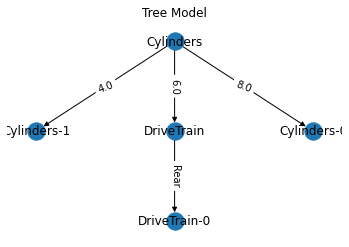

In [12]:
plt.title('Tree Model')
pos = graphviz_layout(m_tree.G, prog='dot')
edges_n = {(u,v):m_tree.G.get_edge_data(u,v)['attr_dict']['name']
           for u,v in m_tree.G.edges()}
nx.draw_networkx_edge_labels(m_tree.G,pos,edge_labels=edges_n)
nx.draw(m_tree.G, pos, with_labels=True, arrows=True)
plt.show()

Como podemos ver en el arbol, la variable principal son los cilindros y despues la variable DriveTrain

## Utilizando una sklearn
Utilizando la libreria de sklearn necesitamos transformar los datos categoricos a numeros


In [13]:
le_dt = preprocessing.LabelEncoder()
le_type = preprocessing.LabelEncoder()
X = dta[features_name]
y = dta["EnvFriendly"]
X["Type"] = le_type.fit_transform(X['Type'])
X["DriveTrain"] = le_dt.fit_transform(X['DriveTrain'])
clf = tree.DecisionTreeClassifier(random_state=0,criterion='entropy')
clf.fit(X, y)

<ipython-input-13-8117567467f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Type"] = le_type.fit_transform(X['Type'])
<ipython-input-13-8117567467f4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["DriveTrain"] = le_dt.fit_transform(X['DriveTrain'])


DecisionTreeClassifier(criterion='entropy', random_state=0)

<AxesSubplot:xlabel='name'>

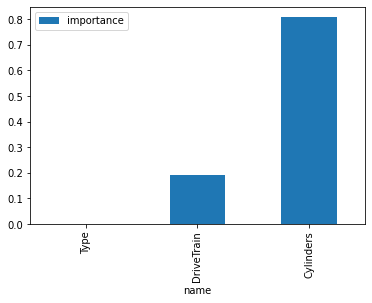

In [14]:
pd.DataFrame([(k,v) for k,v in  zip(features_name,clf.feature_importances_)],
            columns=["name","importance"]).plot.bar(x="name",y="importance")

In [15]:
print(f"catgories type: {le_type.classes_} catgories DriveTrain: {le_dt.classes_}")

catgories type: ['SUV' 'Sedan' 'Sports' 'Wagon'] catgories DriveTrain: ['All' 'Front' 'Rear']


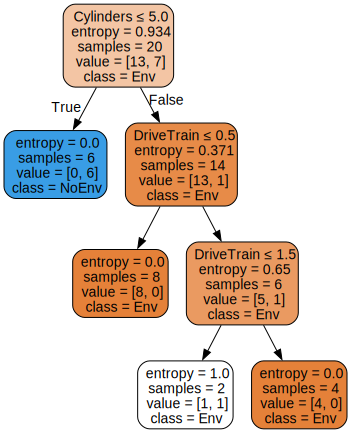

In [16]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features_name,  
                         class_names=["Env","NoEnv"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
rf = RandomForestClassifier(n_estimators=3)
rf.fit(X, y)

RandomForestClassifier(n_estimators=3)

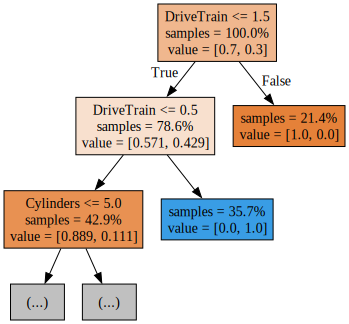

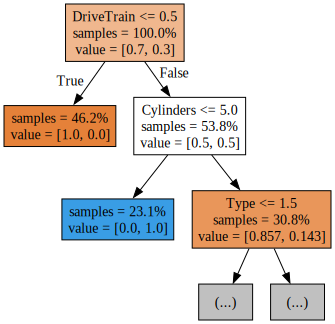

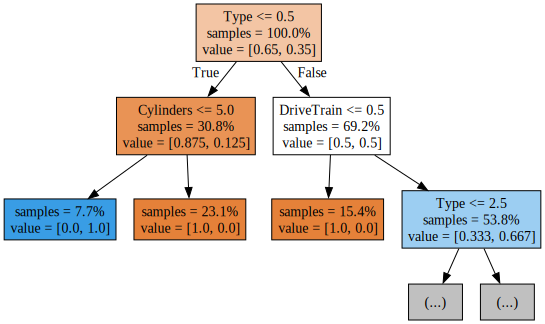

In [19]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

#### GBM GradientBoosting Machines


In [20]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators=3,
                                 learning_rate=1.0,max_depth=3, random_state=0)
gbm.fit(X, y)

GradientBoostingClassifier(learning_rate=1.0, n_estimators=3, random_state=0)

<AxesSubplot:xlabel='name'>

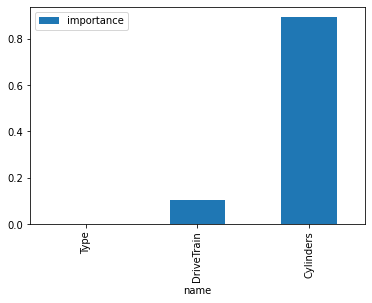

In [21]:
pd.DataFrame([(k,v) for k,v in  zip(features_name,gbm.feature_importances_)],
            columns=["name","importance"]).plot.bar(x="name",y="importance")


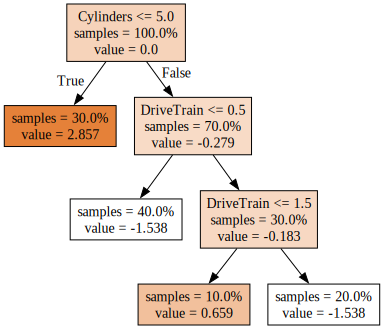

In [23]:
tree = gbm.estimators_[0][0]
dot_data = export_graphviz(tree,
                           feature_names=X.columns,  
                           filled=True,  
                           max_depth=3, 
                           impurity=False, 
                           proportion=True)
graph = graphviz.Source(dot_data)
display(graph)